The goal of this experiment is to just repeat, without guidance, what was done in Karpathy's first video lecture. I'd like to train this MLP to create a decision boundary between two diff categorical points using sklearn's "make_moons" test dataset generator

In [1]:
#Imports
import math
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
from sklearn.datasets import make_moons
from micrograd.nn import * 
from micrograd.engine import * 
from micrograd.drawer import * 

%matplotlib inline

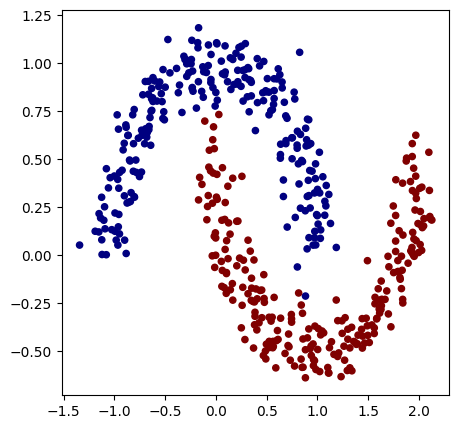

In [2]:
#Using Sklearn.datasets make_moon method to generate some pretty looking "interleaving half circles"
#Added some noise to make it less trivial
X,y = make_moons(n_samples = 500, noise = 0.10)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [3]:
#Let's figure out the shape of our input data and design our MLP from this.

print(X.shape)

#Two dimensional input. 

(500, 2)


In [5]:
#creating an instance of our homemade MLP class with 2 input neurons, a layer with 5 neurons, and another layer with 3 neurons, with 1 output neuron
n = MLP(2,[16,16,1])


In [5]:
#for k in range(20):
#    #Forward pass
#    ypred = [n(x) for x in X]
#    loss = sum(((yout - ygt)**2 for ygt,yout in zip(y,ypred)),Value(0))
#    #Now we do the backward pass
#    for p in n.parameters():
#        p.grad = 0.0
#    loss.backward()

#    #Update. now we do gradient descent
#    ##Changing the data of each of our parameters depending on the gradient they have on the loss function. Gradient descent! 
#    for p in n.parameters():
#        p.data += -0.05 * p.grad
#    print(k,loss.data) 

In [6]:
#draw_dot(loss)